Version:  EECE_Weiss_CNN-LSTM_Car


Using TensorFlow backend.
/home/zhihuilai/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zhihuilai/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zhihuilai/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zhihuilai/.local/lib/python3.6/site-packages/tenso

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 66, 200, 3 0                                            
__________________________________________________________________________________________________
Normalisation (Lambda)          (None, 5, 66, 200, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 5, 31, 98, 24 1824        Normalisation[0][0]              
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 5, 31, 98, 24 96          time_distributed_1[0][0]         
____________________

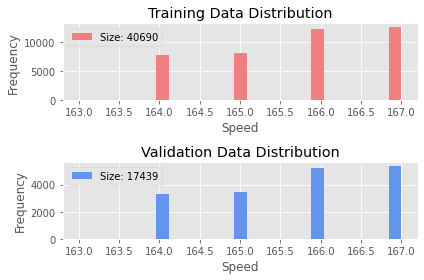

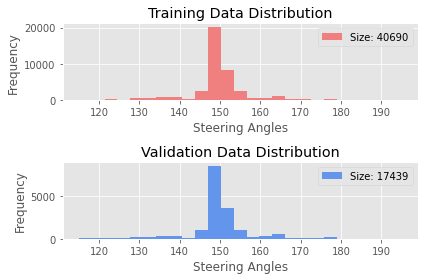

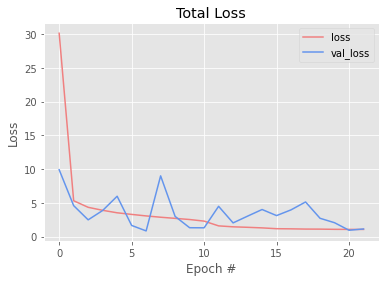

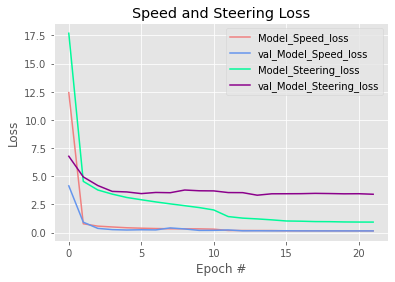

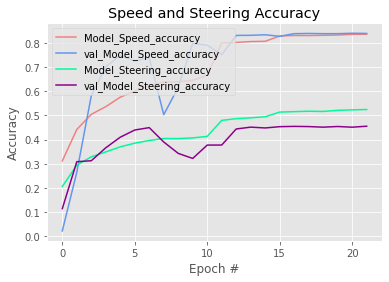

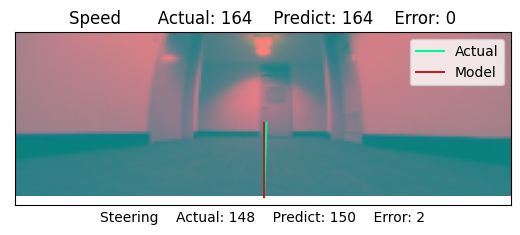

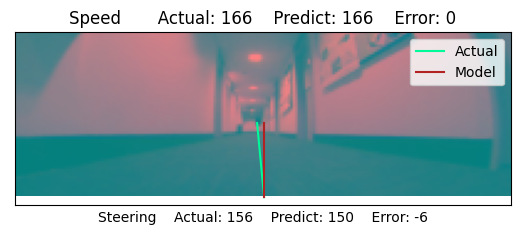

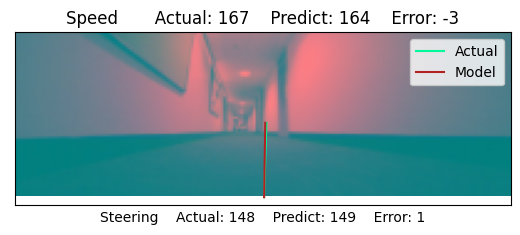

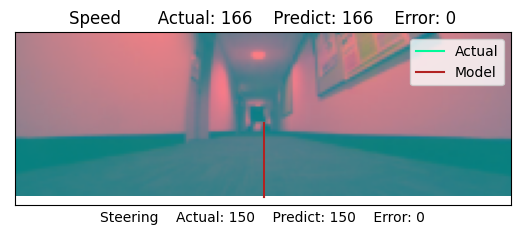

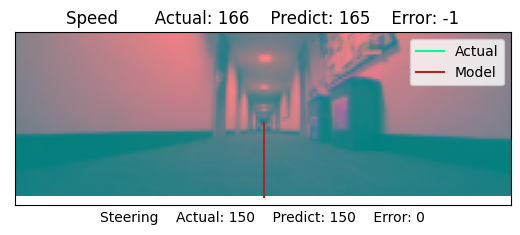

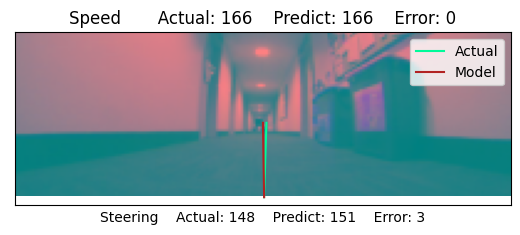

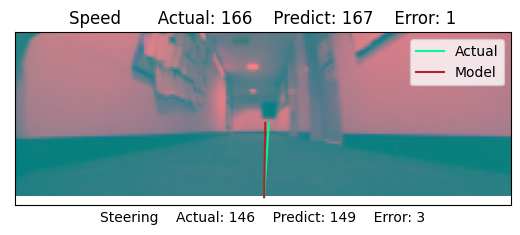

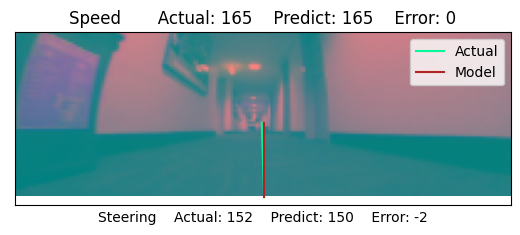

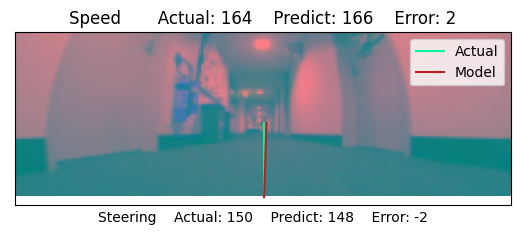

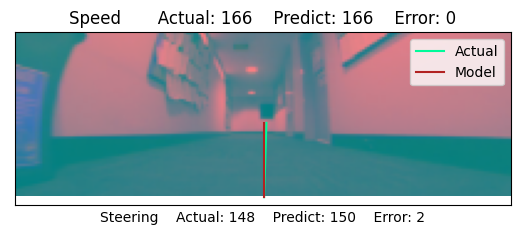

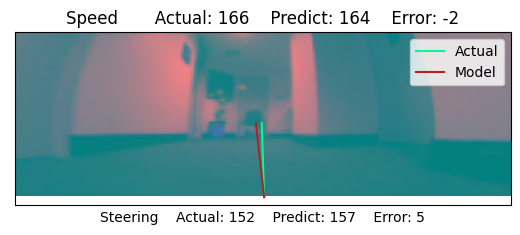

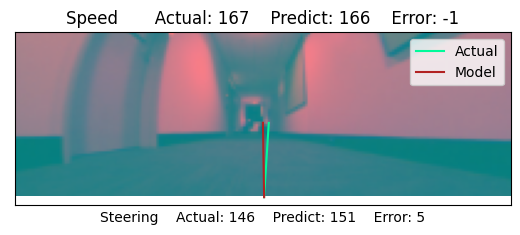

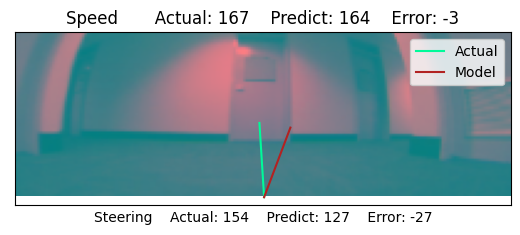

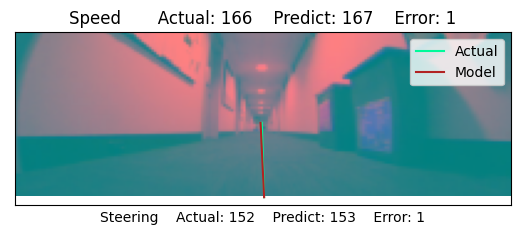

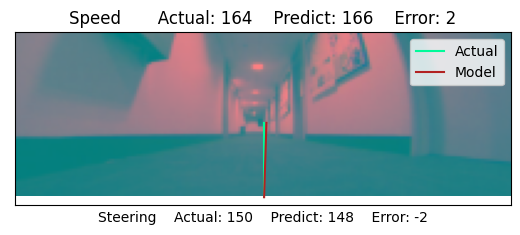

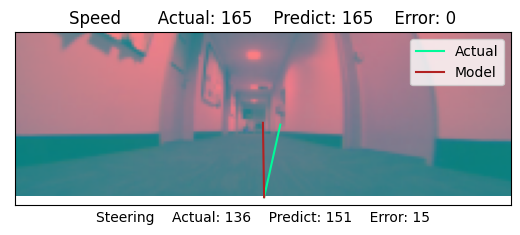

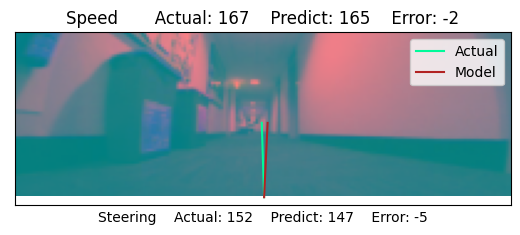

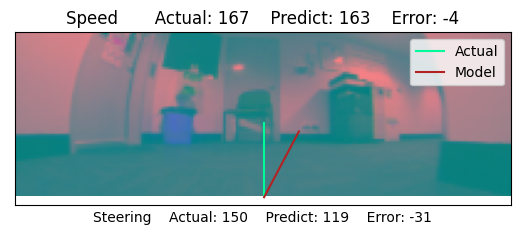

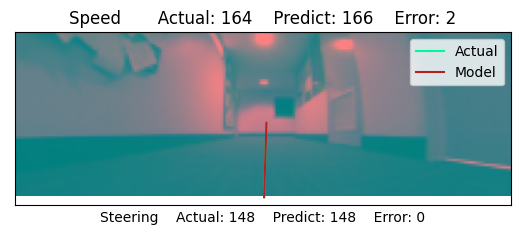

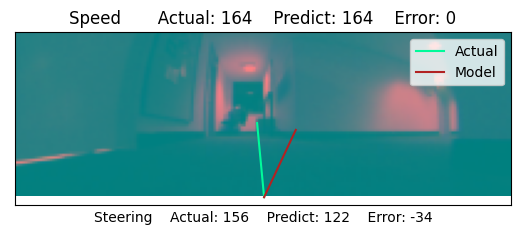

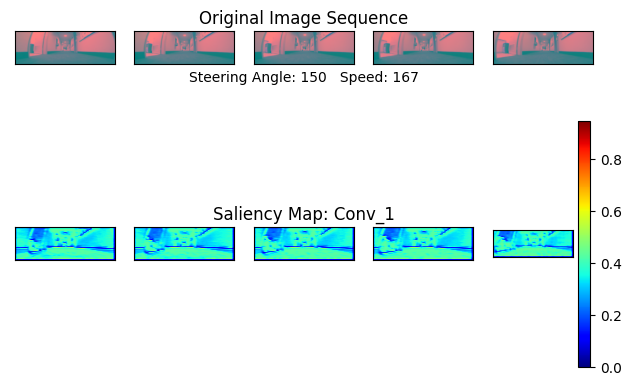

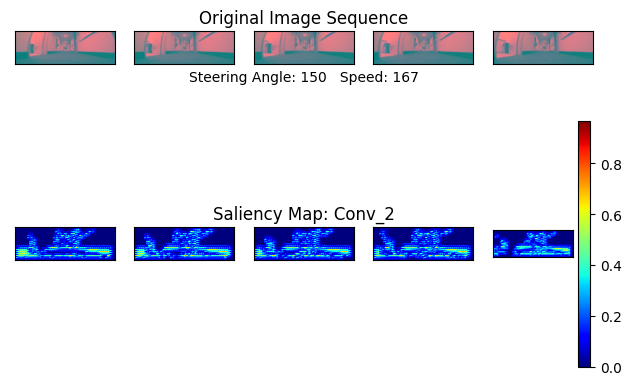

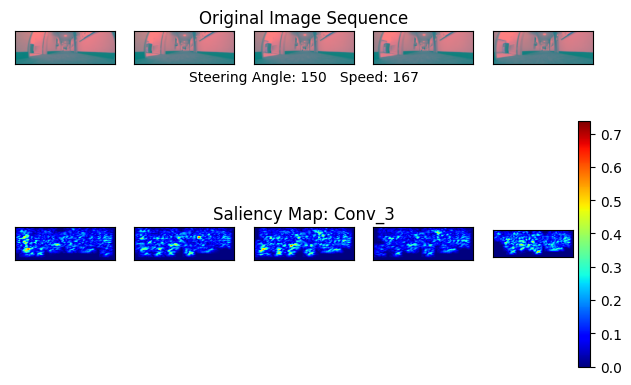

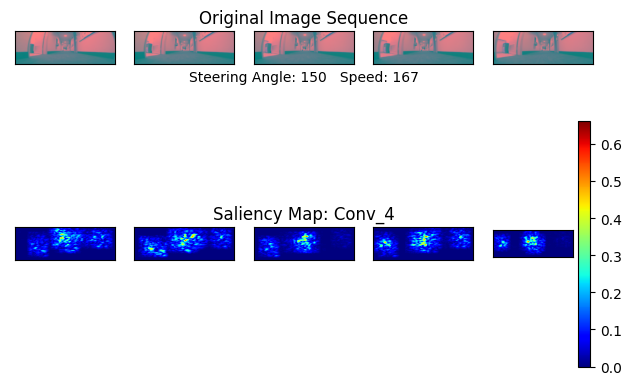

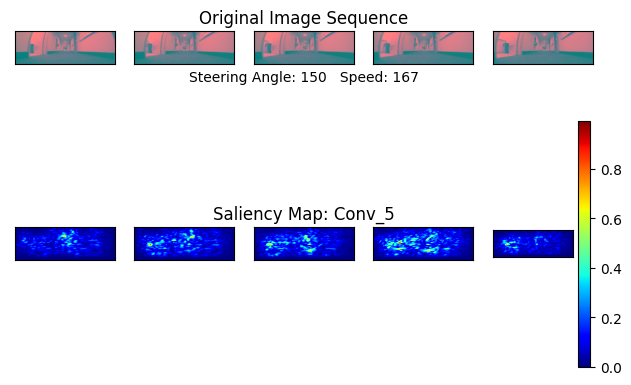

<Figure size 640x480 with 0 Axes>

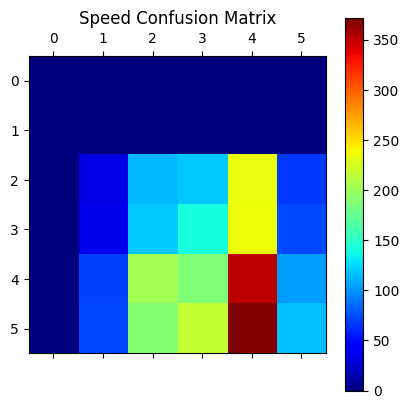

<Figure size 640x480 with 0 Axes>

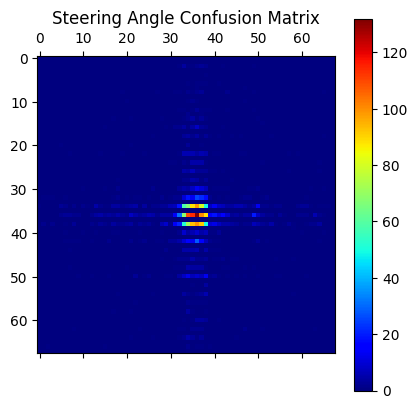

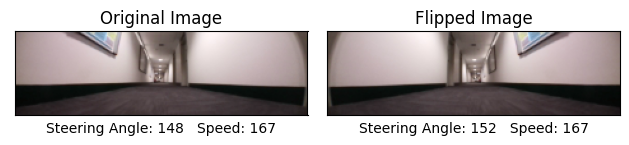

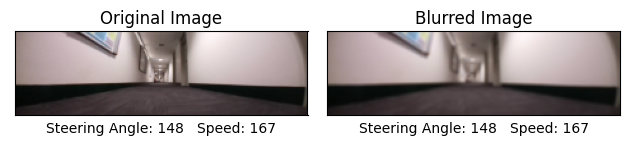

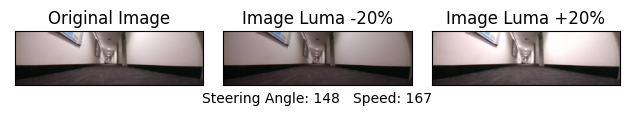

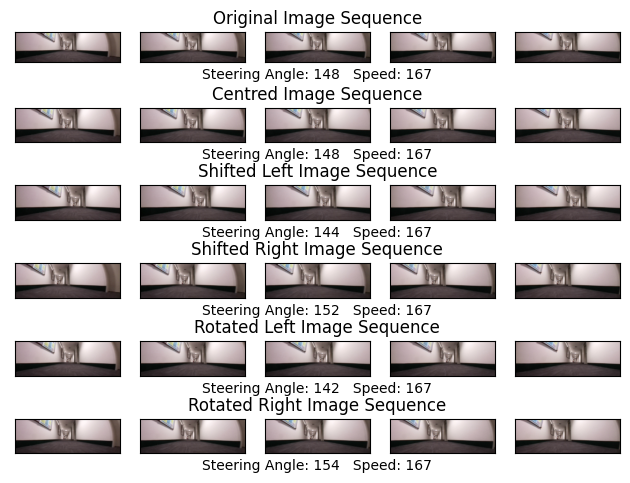

In [1]:
#!/usr/bin/env python3

#=============================================================================
#Environment Settings: Python 3.6.9, Tensorflow-gpu 1.13.1, Keras 2.3.1 
Train_Model = 1
Show_Results = 1
#Model type {0: PilotNet, 1: CNN-LSTM, 2: CNN3D, 3: Weiss_CNN-LSTM}
Model_Type = 3
#Site {0: EECE Loop, 1: CME Corridor, 2: Sim Maze}
Site = 0

#=============================================================================

Epoch = 100
Batch_Size = 32
Test_Size = 20 
if Site==0:
    Site_Name = 'EECE'
    SIMULATION = 0
elif Site==1:
    Site_Name = 'CME'
    SIMULATION = 0
else:
    Site_Name = 'Maze'
    SIMULATION = 1
if Model_Type==0:#PilotNet
    Use_Sequence = 0  
    Model_Name='_PilotNet'
else:#CNN-LSTM or CNN3D
    Use_Sequence = 1
    Sequence_Len = 5
    if Model_Type==1:
        Model_Name='_CNN-LSTM'
    elif Model_Type==2:
        Model_Name='_CNN3D'
    elif Model_Type==3:
        Model_Name='_Weiss_CNN-LSTM'
    else:
        print('[Error!] Wrong model type!')
        sys.exit()
if SIMULATION:
    Env_Name='_Sim'
else:
    Env_Name='_Car'
Version = Site_Name + Model_Name + Env_Name
print("Version: ",Version)

Use_Manual_Images = 0
Show_FPS = 0

#=============================================================================

import pickle
import os
from os.path import join, exists, dirname, abspath
# When paths are too long, program will be slow.
import sys

try:
    import cv2  
                    
except ImportError:
    os.system('sudo -H pip3 install opencv-python')

    try:
        import cv2  
                    
    except ImportError:
        print('[Error!] Cant import OpenCV')
        sys.exit()

try:
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
                    
except ImportError:
    os.system('sudo -H pip3 install matplotlib')
    
    try:
        import matplotlib.pyplot as plt 
        from matplotlib.patches import Rectangle
                    
    except ImportError:
        print('[Error!] Cant import matplotlib')
        sys.exit()
        
try:
    from keras.optimizers import Adam, SGD
    from keras.models import Model, load_model
    from keras.layers import Input, Conv2D, Dropout, Flatten, Dense, Lambda,TimeDistributed, LSTM,GlobalAveragePooling2D,BatchNormalization,GlobalAveragePooling3D,Conv3D
    from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
                        
except ImportError:
    os.system('sudo -H pip3 install keras==2.3.1')
        
    try:
        from keras.optimizers import Adam, SGD
        from keras.models import Model, load_model
        from keras.layers import Input, Conv2D, Dropout, Flatten, Dense, Lambda,TimeDistributed, LSTM,GlobalAveragePooling2D,BatchNormalization,GlobalAveragePooling3D,Conv3D
        from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
                        
    except ImportError:
        print('[Error!] Cant import Keras 2.3.1')
        sys.exit()

try:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix
                    
except ImportError:
    os.system('sudo -H pip3 install sklearn')
    
    try:
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import confusion_matrix
                    
    except ImportError:
        print('[Error!] Cant import SKLearn')
        sys.exit()
try:
    from vis.utils import utils
    from vis.visualization import visualize_saliency
                    
except ImportError:
    os.system('sudo -H pip3 install https://github.com/raghakot/keras-vis/archive/master.zip')
    
    try:
        from vis.utils import utils
        from vis.visualization import visualize_saliency
                    
    except ImportError:
        print('[Error!] Cant import Keras-Vis')
        sys.exit()

import numpy as np

#=============================================================================
    
#Script = dirname(abspath(__file__))
#ModelCar_Path = Script[:-9]
ModelCar_Path = dirname(abspath(''))
Data_Path = join(ModelCar_Path, 'Data')
Training_Results_Path = join(Data_Path, Version)
Model_Path = join(Training_Results_Path, Version + '.h5')
Check_Path = join(Training_Results_Path, 'Model_Check.h5')
History_Path = join(Training_Results_Path, 'History.pickle')
Test_result_Path = join(Training_Results_Path, 'Test_result.pickle')
Prediction_Path = join(Training_Results_Path, 'Predictions')
Image_Folder = join(Data_Path, 'Images'+Env_Name)
if Show_FPS:
    Manual_Path = join(Data_Path, 'Manual'+Env_Name+'.npy')
    Nvidia_Camera_Path = join(Data_Path, 'Nvidia_Camera'+Env_Name+'.npy')
    Lidar_Path = join(Data_Path, 'Lidar'+Env_Name+'.npy')
if Use_Sequence:
    #Image_Tensor_Path = join(Image_Folder, Site_Name +'_Tensors')
    Image_Tensor_Path = "/media/zhihuilai/RAID1/Erik-ModelCar-Data/EECE_Tensors_Processed"
else:
    #Image_Path = join(Image_Folder, Site_Name +'_Images')
    Image_Path = "/media/zhihuilai/RAID1/Erik-ModelCar-Data/CME_Images_Processed"
if Use_Manual_Images:
    Image_Tensor_M1_Path = join(Image_Folder, Site_Name +'_Tensors_M1')
    Image_Tensor_M2_Path = join(Image_Folder, Site_Name +'_Tensors_M2')
            
#=============================================================================
      
if exists(Training_Results_Path):
    if(len(os.listdir(Training_Results_Path)) <= 1):
        os.system('rm -rf ' + Training_Results_Path)    
else:
    os.makedirs(Training_Results_Path)
    
if not exists(Prediction_Path) and Show_Results:
    os.makedirs(Prediction_Path)
        
plt.close("all")
    
#=============================================================================
    
Images = []
Speeds = []
Steering_Angles = []
Images_All = []
Speeds_All = []
Steering_Angles_All = []

if Use_Sequence:
    if exists(Image_Tensor_Path):
        for tensor in os.listdir(Image_Tensor_Path):
            img_tensor_array = np.load(join(Image_Tensor_Path, tensor), allow_pickle=True)
            Images_All.append(img_tensor_array[0][:Sequence_Len])
            Speeds_All.append(img_tensor_array[1])
            Steering_Angles_All.append(img_tensor_array[2])
        if Use_Manual_Images:
            for tensor in os.listdir(Image_Tensor_M1_Path):
                img_tensor_array = np.load(join(Image_Tensor_M1_Path, tensor), allow_pickle=True)
                Images_All.append(img_tensor_array[0][:Sequence_Len])
                Speeds_All.append(img_tensor_array[1])
                Steering_Angles_All.append(img_tensor_array[2])
            for tensor in os.listdir(Image_Tensor_M2_Path):
                img_tensor_array = np.load(join(Image_Tensor_M2_Path, tensor), allow_pickle=True)
                Images_All.append(img_tensor_array[0][:Sequence_Len])
                Speeds_All.append(img_tensor_array[1])
                Steering_Angles_All.append(img_tensor_array[2])
    else:
        print('[Error!] Check Image Tensor Directory is Correct!')
        sys.exit()   
else:
    if exists(Image_Path):
        for Filepath in os.listdir(Image_Path):
            Search_Folder = join(Image_Path, Filepath)
            for Folders in os.listdir(Search_Folder):
                img_array = np.load(join(Search_Folder, Folders), allow_pickle=True)
                Images_All.append(img_array[0])
                Speeds_All.append(img_array[1])
                Steering_Angles_All.append(img_array[2])
    else:
        print('[Error!] Check Image Directory is Correct!')
        sys.exit()        

Split_a = train_test_split(Images_All, Speeds_All, Steering_Angles_All, test_size=0.05, shuffle=True)
(Images, Image_Test, Speeds, Speed_Test, Steering_Angles, Steering_Angle_Test) = Split_a   
Split_b = train_test_split(Images, Speeds, Steering_Angles, test_size=0.3, shuffle=True)
(Image_Train, Image_Valid, Speed_Train, Speed_Valid, Steering_Angle_Train, Steering_Angle_Valid) = Split_b
 
#=============================================================================
    
if SIMULATION:
    def Image_Processing(image):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        #image = cv2.GaussianBlur(image, (3, 3), 0)
        image = cv2.resize(image, (230, 66))
        return image 
else:   #reality
    def Image_Processing(image):
        image = image[60:165, :, :]
        image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        #image = cv2.GaussianBlur(image, (3, 3), 0)
        image = cv2.resize(image, (230, 66))
        return image
    
#=============================================================================
if Use_Sequence:
    def Blur(image, steering_angle):
        blurred = []
        for j in range (Sequence_Len):
            blurred.append(cv2.blur(image[j], (3, 3)))
            #diameter, sigmaColor, sigmaSpace=11, 21, 7
            #blurred.append(cv2.bilateralFilter(image[j], diameter, sigmaColor, sigmaSpace))
        image=np.asarray(blurred)
        return image, steering_angle
    def Flip(image, steering_angle):
        flipped = []
        for j in range (Sequence_Len):
            flipped.append(cv2.flip(image[j], 1))
        image=np.asarray(flipped)
        steering_angle = 300 - steering_angle
        return image, steering_angle
    def Bright(image, steering_angle,set_brightness=0):
        modified = []
        for j in range (Sequence_Len):
            y, u, v = cv2.split(image[j])
            p=0.8+0.4*np.random.rand()
            if set_brightness:
                p=set_brightness
            y=np.around(y*p)
            y[y>255]=255
            y[y<0]=0
            y=np.asarray(y,dtype="uint8")
            modified.append(cv2.merge([y,u,v]))
        image=np.asarray(modified)
        return image, steering_angle

    def Centre(image, steering_angle):
        image=np.asarray(image[:,:, 15:215, :])
        return image, steering_angle
    def Shift_Left(image, steering_angle):
        image=np.asarray(image[:,:, :200, :])
        if 120<steering_angle<180:
            steering_angle = steering_angle-4
        return image, steering_angle
    def Shift_Right(image, steering_angle):
        image=np.asarray(image[:,:, 30:, :])
        if 120<steering_angle<180:
            steering_angle = steering_angle+4
        return image, steering_angle
    def Rotate_Left(image, steering_angle):
        clipped=[]
        for j in range (Sequence_Len):
            clipped.append(image[j,:,15-3*(j+1):215-3*(j+1),:])
        image=np.asarray(clipped)
        if 120<steering_angle<180:
            steering_angle = steering_angle-6
        return image, steering_angle
    def Rotate_Right(image, steering_angle):
        clipped=[]
        for j in range (Sequence_Len):
            clipped.append(image[j,:,15+3*(j+1):215+3*(j+1),:])
        image=np.asarray(clipped)
        if 120<steering_angle<180:
            steering_angle = steering_angle+6
        return image, steering_angle

    def Data_Augmentation(image, steering_angle):

        if(np.random.rand() < 0.05):
            image, steering_angle = Blur(image, steering_angle)

        #if(np.random.rand() < 0.05):
        #    image, steering_angle = Flip(image, steering_angle)

        if(np.random.rand() < 0.05):
            image, steering_angle = Bright(image, steering_angle)

        return image, steering_angle
    def Data_Shifting(image, steering_angle):
        random_num=np.random.rand() 
        if(random_num < 0.15):
            image, steering_angle = Shift_Left(image, steering_angle)

        elif(random_num > 0.85):
            image, steering_angle = Shift_Right(image, steering_angle)

        elif(random_num < 0.3):
            image, steering_angle = Rotate_Left(image, steering_angle)

        elif(random_num > 0.7):
            image, steering_angle = Rotate_Right(image, steering_angle)

        else:
            image, steering_angle = Centre(image, steering_angle)

        return image, steering_angle
else:#No Sequence
    def Blur(image, steering_angle):
        image = cv2.blur(image, (3, 3))
        #diameter, sigmaColor, sigmaSpace=11, 21, 7
        #image = cv2.bilateralFilter(image, diameter, sigmaColor, sigmaSpace)
        return image, steering_angle   
    def Flip(image, steering_angle):
        image = cv2.flip(image, 1)
        steering_angle = 300 - steering_angle
        return image, steering_angle
    def Bright(image, steering_angle,set_brightness=0):
        y, u, v = cv2.split(image)
        p=0.8+0.4*np.random.rand()
        if set_brightness:
            p=set_brightness
        y=np.around(y*p)
        y[y>255]=255
        y[y<0]=0
        y=np.asarray(y,dtype="uint8")
        image=cv2.merge([y,u,v])
        return image, steering_angle
    def Centre(image, steering_angle):
        image=np.asarray(image[:, 15:215, :])
        return image, steering_angle
    def Shift_Left(image, steering_angle):
        image=np.asarray(image[:, :200, :])
        steering_angle = steering_angle-4
        return image, steering_angle
    def Shift_Right(image, steering_angle):
        image=np.asarray(image[:, 30:, :])
        steering_angle = steering_angle+4
        return image, steering_angle   
    def Data_Augmentation(image, steering_angle):

        if(np.random.rand() < 0.05):
            image, steering_angle = Blur(image, steering_angle)

        #if(np.random.rand() < 0.05):
        #    image, steering_angle = Flip(image, steering_angle)

        if(np.random.rand() < 0.05):
            image, steering_angle = Bright(image, steering_angle)

        return image, steering_angle
    def Data_Shifting(image, steering_angle):
        random_num=np.random.rand() 
        if(random_num < 0.3):
            image, steering_angle = Shift_Left(image, steering_angle)

        elif(random_num > 0.7):
            image, steering_angle = Shift_Right(image, steering_angle)

        else:
            image, steering_angle = Centre(image, steering_angle)

        return image, steering_angle
#=============================================================================
if not Use_Sequence:
    for i in range(len(Image_Test)):
        Image_Test[i]=Image_Processing(Image_Test[i])
#Image_Test = np.asarray(Image_Test[:Test_Size])
#Speed_Test = np.asarray(Speed_Test[:Test_Size])
#Steering_Angle_Test = np.asarray(Steering_Angle_Test[:Test_Size])
Image_Test = np.asarray(Image_Test)
Speed_Test = np.asarray(Speed_Test)
Steering_Angle_Test = np.asarray(Steering_Angle_Test)
if Use_Sequence:
    Image_Test=np.asarray(Image_Test[:,:,:,15:215,:])
else:
    Image_Test=np.asarray(Image_Test[:,:,15:215,:])
np.random.shuffle(Image_Test)
np.random.shuffle(Speed_Test)
np.random.shuffle(Steering_Angle_Test)    

#=============================================================================  
if Use_Sequence:
    def CNN_LSTM():
        Input_Shape = Input(shape=(Sequence_Len, 66, 200, 3))
        X = Input_Shape
        X = (Lambda(lambda x: (x/127.5 - 1.0), name='Normalisation'))(X)
        X = (TimeDistributed(Conv2D(24, (5, 5), strides=(2, 2), activation='elu', name='Conv_1')))(X)
        X = (TimeDistributed(BatchNormalization()))(X)
        X = (TimeDistributed(Conv2D(36, (5, 5), strides=(2, 2), activation='elu', name='Conv_2')))(X)
        X = (TimeDistributed(BatchNormalization()))(X)
        X = (TimeDistributed(Conv2D(48, (5, 5), strides=(2, 2), activation='elu', name='Conv_3')))(X)
        X = (TimeDistributed(BatchNormalization()))(X)
        X = (TimeDistributed(Conv2D(64, (3, 3), strides=(1, 1), activation='elu', name='Conv_4')))(X)
        X = (TimeDistributed(BatchNormalization()))(X)
        X = (TimeDistributed(Conv2D(64, (3, 3), strides=(1, 1), activation='elu', name='Conv_5')))(X)
        X = (TimeDistributed(BatchNormalization()))(X)
        X = (TimeDistributed(GlobalAveragePooling2D()))(X)
        X = (Dropout(0.2))(X)
        X = (LSTM(128, activation='elu', return_sequences=False))(X)
        X = (Dense(100, activation='elu'))(X)
        X = (Dense(50, activation='elu'))(X)
        X = (Dense(10, activation='elu'))(X)
        Model_Speed = (Dense(1, name='Model_Speed'))(X)
        Model_Steering = (Dense(1, name='Model_Steering'))(X)
        model = Model(inputs = [Input_Shape], outputs = [Model_Speed, Model_Steering])
        model.compile(loss = ['mse', 'mse'], loss_weights = [1, 2], optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
        model.summary() 
        return model
    def Weiss_CNN_LSTM():
        Input_Shape = Input(shape=(Sequence_Len, 66, 200, 3))
        X = Input_Shape
        X = (Lambda(lambda x: (x/127.5 - 1.0), name='Normalisation'))(X)
        X = (TimeDistributed(Conv2D(24, (5, 5), strides=(2, 2), activation='elu', name='Conv_1')))(X)
        X = (TimeDistributed(BatchNormalization()))(X)
        X = (TimeDistributed(Conv2D(36, (5, 5), strides=(2, 2), activation='elu', name='Conv_2')))(X)
        X = (TimeDistributed(BatchNormalization()))(X)
        X = (TimeDistributed(Conv2D(48, (5, 5), strides=(2, 2), activation='elu', name='Conv_3')))(X)
        X = (TimeDistributed(BatchNormalization()))(X)
        X = (TimeDistributed(Conv2D(64, (3, 3), strides=(1, 1), activation='elu', name='Conv_4')))(X)
        X = (TimeDistributed(BatchNormalization()))(X)
        X = (TimeDistributed(Conv2D(64, (3, 3), strides=(1, 1), activation='elu', name='Conv_5')))(X)
        X = (TimeDistributed(Flatten()))(X)
        X = (LSTM(100, activation='elu', return_sequences=False))(X)
        Model_Speed = (Dense(1, name='Model_Speed'))(X)
        Model_Steering = (Dense(1, name='Model_Steering'))(X)
        model = Model(inputs = [Input_Shape], outputs = [Model_Speed, Model_Steering])
        #model.compile(loss = ['mse', 'mse'], loss_weights = [1, 2], optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
        model.compile(loss = ['mse', 'mse'], optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
        model.summary() 
        return model
    def CNN_3D():
        Input_Shape = Input(shape=(Sequence_Len, 66, 200, 3))
        X = Input_Shape
        X = (Lambda(lambda x: (x/127.5 - 1.0), name='Normalisation'))(X)
        X = (Conv3D(24, (2 ,5, 5), strides=(1, 2, 2), activation='elu', name='Conv_1'))(X)
        X = (BatchNormalization())(X)
        X = (Conv3D(36, (2 ,5, 5), strides=(1, 2, 2), activation='elu', name='Conv_2'))(X)
        X = (BatchNormalization())(X)
        X = (Conv3D(48, (2 ,5, 5), strides=(1, 2, 2), activation='elu', name='Conv_3'))(X)
        X = (BatchNormalization())(X)
        X = (Conv3D(64, (1 ,3, 3), strides=(1, 1, 1), activation='elu', name='Conv_4'))(X)
        X = (BatchNormalization())(X)
        X = (Conv3D(64, (1 ,3, 3), strides=(1, 1, 1), activation='elu', name='Conv_5'))(X)
        X = (BatchNormalization())(X)
        X = (GlobalAveragePooling3D())(X)
        X = (Dropout(0.2))(X)
        X = (Dense(100, activation='elu'))(X)
        X = (Dense(50, activation='elu'))(X)
        X = (Dense(10, activation='elu'))(X)
        Model_Speed = (Dense(1, name='Model_Speed'))(X)
        Model_Steering = (Dense(1, name='Model_Steering'))(X)
        model = Model(inputs = [Input_Shape], outputs = [Model_Speed, Model_Steering])
        model.compile(loss = ['mse', 'mse'], loss_weights = [1, 2], optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
        model.summary() 
        return model
else:
    def PilotNet():
        Input_Shape = Input(shape=(66, 200, 3))
        X = Input_Shape
        X = (Lambda(lambda x: (x/127.5 - 1.0), name='Normalisation'))(X)
        X = (Conv2D(24, (5, 5), strides=(2, 2), activation='elu', name='Conv_1'))(X)
        X = (BatchNormalization())(X)
        X = (Conv2D(36, (5, 5), strides=(2, 2), activation='elu', name='Conv_2'))(X)
        X = (BatchNormalization())(X)
        X = (Conv2D(48, (5, 5), strides=(2, 2), activation='elu', name='Conv_3'))(X)
        X = (BatchNormalization())(X)
        X = (Conv2D(64, (3, 3), strides=(1, 1), activation='elu', name='Conv_4'))(X)
        X = (BatchNormalization())(X)
        X = (Conv2D(64, (3, 3), strides=(1, 1), activation='elu', name='Conv_5'))(X)
        X = (BatchNormalization())(X)
        X = (Flatten())(X)
        X = (Dropout(0.2))(X)
        X = (Dense(100, activation='elu'))(X)
        X = (Dense(50, activation='elu'))(X)
        X = (Dense(10, activation='elu'))(X)
        Model_Speed = (Dense(1, name='Model_Speed'))(X)
        Model_Steering = (Dense(1, name='Model_Steering'))(X)
        model = Model(inputs = [Input_Shape], outputs = [Model_Speed, Model_Steering])
        model.compile(loss = ['mse', 'mse'], loss_weights = [1, 2], optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
        model.summary() 
        return model
#=============================================================================
      
def Image_Generator(Images, Speeds, Steering_Angles, Batch_Size, Augment_Data,Shift_Data):
    
    while(True):
        X = []
        Y1 = []
        Y2 = []
        
        for i in range(Batch_Size):
            random = np.random.randint(0, len(Images) - 1)
            Image = Images[random]
            Speed = Speeds[random]
            Steering_Angle = Steering_Angles[random]
            if not Use_Sequence:
                Image = Image_Processing(Image)
            if Augment_Data:
                Image, Steering_Angle = Data_Augmentation(Image, Steering_Angle)
            if Shift_Data:
                Image, Steering_Angle = Data_Shifting(Image, Steering_Angle)
            else:
                Image, Steering_Angle = Centre(Image, Steering_Angle)  
            X.append(Image)
            Y1.append(Speed)
            Y2.append(Steering_Angle)
            
        yield (np.asarray(X)), [(np.asarray(Y1)), (np.asarray(Y2))]
                  
#=============================================================================
    
if Train_Model:
    
    #if((sys.platform == 'linux') or (sys.platform == 'linux2')):
    #    os.system('export CUDA_VISIBLE_DEVICES=0,1')
    
    if exists(Model_Path):
        model = load_model(Model_Path)
        
        with open(History_Path, 'rb') as F:
            Old_History = pickle.load(F)
            
        os.remove(History_Path)
        New_Model = False

    else:
        if Model_Type==1:
            model = CNN_LSTM()
        elif Model_Type==2:
            model = CNN_3D()
        elif Model_Type==3:
            model = Weiss_CNN_LSTM()
        else:
            model = PilotNet()
        #checkpoint loading
        #model=load_model(Check_Path)
        New_Model = True
        
    Checkpoint = ModelCheckpoint(Check_Path, monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
    Stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
    ReduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.000001, verbose=1)
    Callback = [Checkpoint, Stopping, ReduceLR]

    #Auto Steps
    Train_coeff=9
    Valid_coeff=9
    Train_Steps=round(Train_coeff*len(Image_Train)/Batch_Size)
    Valid_Steps=round(Valid_coeff*len(Image_Valid)/Batch_Size)

    Train = Image_Generator(Image_Train, Speed_Train, Steering_Angle_Train, Batch_Size, True, True)
    Valid = Image_Generator(Image_Valid, Speed_Valid, Steering_Angle_Valid, Batch_Size, True, False)
    history = model.fit(Train, epochs=Epoch, validation_data=Valid, steps_per_epoch=Train_Steps, validation_steps=Valid_Steps, callbacks=Callback, verbose=1, shuffle=True)
    model.save(Model_Path)

    if(New_Model == False):
        New_History = history.history
        History = {**Old_History, **New_History}
        
    else:
        History = history.history
        
    with open(History_Path, 'wb') as F:
        pickle.dump(History, F, pickle.HIGHEST_PROTOCOL)
    Test_result=model.evaluate(Image_Test,[Speed_Test, Steering_Angle_Test],verbose=1)
    print("Test_result: ",Test_result)
    with open(Test_result_Path, 'wb') as F:
        pickle.dump(Test_result, F, pickle.HIGHEST_PROTOCOL)
#=============================================================================
    
    plt.style.use('ggplot')
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.hist(Speed_Train, bins=25, color='lightcoral', label='Size: %d' %(len(Speed_Train)))
    plt.title('Training Data Distribution')
    plt.xlabel('Speed')
    plt.ylabel('Frequency')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.hist(Speed_Valid, bins=25, color='cornflowerblue', label='Size: %d' %(len(Speed_Valid)))
    plt.title('Validation Data Distribution')
    plt.xlabel('Speed')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.savefig(join(Training_Results_Path, 'Speed_Histogram.png'), dpi=1000)
    plt.show()

    plt.figure()
    plt.subplot(2, 1, 1)
    plt.hist(Steering_Angle_Train, bins=25, color='lightcoral', label='Size: %d' %(len(Steering_Angle_Train)))
    plt.title('Training Data Distribution')
    plt.xlabel('Steering Angles')
    plt.ylabel('Frequency')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.hist(Steering_Angle_Valid, bins=25, color='cornflowerblue', label='Size: %d' %(len(Steering_Angle_Valid)))
    plt.title('Validation Data Distribution')
    plt.xlabel('Steering Angles')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.savefig(join(Training_Results_Path, 'Steering_Histogram.png'), dpi=1000)
    plt.show()
        
#=============================================================================
    
    plt.figure()       
    plt.plot(History['loss'], color='lightcoral', label='loss')
    plt.plot(History['val_loss'], color='cornflowerblue', label='val_loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right') 
    plt.savefig(join(Training_Results_Path, 'Total_Loss.png' ), dpi=1000)
    plt.show()
    
    plt.figure()       
    plt.plot(History['Model_Speed_loss'], color='lightcoral', label='Model_Speed_loss')
    plt.plot(History['val_Model_Speed_loss'], color='cornflowerblue', label='val_Model_Speed_loss')
    plt.plot(History['Model_Steering_loss'], color='mediumspringgreen', label='Model_Steering_loss')
    plt.plot(History['val_Model_Steering_loss'], color='darkmagenta', label='val_Model_Steering_loss')
    plt.title('Speed and Steering Loss')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right') 
    plt.savefig(join(Training_Results_Path, 'Speed_Steering_Loss.png' ), dpi=1000)
    plt.show()
    
    plt.figure()
    plt.plot(History['Model_Speed_accuracy'], color='lightcoral', label='Model_Speed_accuracy')
    plt.plot(History['val_Model_Speed_accuracy'], color='cornflowerblue', label='val_Model_Speed_accuracy')
    plt.plot(History['Model_Steering_accuracy'], color='mediumspringgreen', label='Model_Steering_accuracy')
    plt.plot(History['val_Model_Steering_accuracy'], color='darkmagenta', label='val_Model_Steering_accuracy')
    plt.title('Speed and Steering Accuracy')
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.savefig(join(Training_Results_Path, 'Speed_Steering_Accuracy.png'), dpi=1000)
    plt.show()
        

        
#=============================================================================
    
if Show_Results:
    
    if(exists(Model_Path) == True):
        model = load_model(Model_Path)
        (Speed_Model, Steering_Angle_Model) = model.predict(Image_Test)
        Speed_Error = []
        Steering_Angle_Error = []
        Speed_Error_Square = []
        Speed_Mean_Error_Square = []
        Speed_Test_Mean=np.mean(Speed_Test)
        for i in range(len(Image_Test)):
            Speed_Error.append(int(Speed_Model[i]) - Speed_Test[i])
            #Speed_Error_Square.append((int(Speed_Model[i]) - Speed_Test[i])**2)
            #Speed_Mean_Error_Square.append((Speed_Test_Mean - Speed_Test[i])**2)
            Steering_Angle_Error.append(int(Steering_Angle_Model[i]) - Steering_Angle_Test[i])
        #Speed_Error_Square_Sum=sum(Speed_Error_Square)
        #Speed_Mean_Error_Square_Sum=sum(Speed_Mean_Error_Square)
        #print("Speed R_square=",1-Speed_Error_Square_Sum/Speed_Mean_Error_Square_Sum)

#=============================================================================

        X_Start = 100
        Y_Start = 66
        Length = 30
        
        #for i in range(len(Image_Test)):
        for i in range(Test_Size):
            X_Finish_Actual = X_Start + (Length*np.sin(np.deg2rad((-9/10)*Steering_Angle_Test[i] + 135)))
            Y_Finish_Actual = Y_Start - (Length*np.cos(np.deg2rad((-9/10)*Steering_Angle_Test[i] + 135)))
            
            X_Finish_Model = X_Start + (Length*np.sin(np.deg2rad((-9/10)*int(Steering_Angle_Model[i]) + 135)))
            Y_Finish_Model = Y_Start - (Length*np.cos(np.deg2rad((-9/10)*int(Steering_Angle_Model[i]) + 135)))
            
            plt.style.use('default')
            if Use_Sequence:
                plt.imshow(Image_Test[i][Sequence_Len-1])
            else:
                plt.imshow(Image_Test[i])
            plt.plot([X_Start, X_Finish_Actual], [Y_Start, Y_Finish_Actual], color='mediumspringgreen', label='Actual')
            plt.plot([X_Start, X_Finish_Model], [Y_Start, Y_Finish_Model], color='firebrick', label='Model')
            plt.title('Speed       Actual: %d    Predict: %d    Error: %d' %(Speed_Test[i], int(Speed_Model[i]), Speed_Error[i]))
            plt.xlabel('Steering    Actual: %d    Predict: %d    Error: %d' %(Steering_Angle_Test[i], int(Steering_Angle_Model[i]), Steering_Angle_Error[i]))
            plt.xticks([])
            plt.yticks([])
            plt.legend()  
            plt.savefig(join(Prediction_Path, 'Prediction_%03d.png' %(i)), dpi=1000)
            plt.show()


#=============================================================================
    if exists(Model_Path):
        model = load_model(Model_Path)
        if Use_Sequence:
            Layer1 = 2
            Layer2 = 4
            Layer3 = 6
            Layer4 = 8
            Layer5 = 10
        else:
            Layer1 = utils.find_layer_idx(model, 'Conv_1')
            Layer2 = utils.find_layer_idx(model, 'Conv_2')
            Layer3 = utils.find_layer_idx(model, 'Conv_3')
            Layer4 = utils.find_layer_idx(model, 'Conv_4')
            Layer5 = utils.find_layer_idx(model, 'Conv_5')
        Layer_List = [Layer1, Layer2, Layer3, Layer4, Layer5]
        Layer_Count = 1
        
        Random = np.random.randint(0, len(Image_Test) - 1)
        Image = Image_Test[Random]
        Steering_Angle = Steering_Angle_Test[Random]
        Speed = Speed_Test[Random]
        
        for Layer in Layer_List:
            Saliency = visualize_saliency(model, Layer, filter_indices=0, seed_input=Image)
            
            plt.figure()
            if Use_Sequence:
                for i in range(Sequence_Len):
                    plt.subplot(2, Sequence_Len, i+1)
                    plt.imshow(Image[i])
                    if i==round(Sequence_Len/2):
                        plt.title('Original Image Sequence')
                        plt.xlabel('Steering Angle: %d   Speed: %d' %(Steering_Angle, Speed))
                    plt.xticks([])
                    plt.yticks([])                    
            else:
                plt.subplot(2, 1, 1)
                plt.imshow(Image)
                plt.title('Original Image')
                plt.xlabel('Steering Angle: %d   Speed: %d' %(Steering_Angle, Speed))
                plt.xticks([])
                plt.yticks([])
            if Use_Sequence:
                for i in range(Sequence_Len):
                    plt.subplot(2, Sequence_Len, i+Sequence_Len+1)            
                    plt.imshow(Saliency[i], cmap='jet')
                    if i==round(Sequence_Len/2):
                        plt.title('Saliency Map: Conv_%d' %(Layer_Count))
                    plt.xticks([])
                    plt.yticks([])     
            else:
                plt.subplot(2, 1, 2)
                plt.imshow(Saliency, cmap='jet')
                plt.title('Saliency Map: Conv_%d' %(Layer_Count))
                plt.xticks([])
                plt.yticks([])
            plt.colorbar()
            plt.tight_layout() 
            plt.savefig(join(Training_Results_Path, 'Saliency_Conv_%d.png' %(Layer_Count)), dpi=1000)
            plt.show()    

            Layer_Count += 1
        
        Speed_Model = np.asarray(Speed_Model, dtype='int64')
        Speed_Model = Speed_Model.tolist()
        Speed_Confusion = confusion_matrix(Speed_Test, Speed_Model)
        plt.figure()
        plt.matshow(Speed_Confusion, cmap='jet')
        plt.colorbar()
        plt.title('Speed Confusion Matrix')
        plt.savefig(join(Training_Results_Path, 'Speed_Confusion.png'), dpi=1000)
        plt.show()
    
        Steering_Angle_Model = np.asarray(Steering_Angle_Model, dtype='int64')
        Steering_Angle_Model = Steering_Angle_Model.tolist()
        Steering_Confusion = confusion_matrix(Steering_Angle_Test, Steering_Angle_Model)
        plt.figure()
        plt.matshow(Steering_Confusion, cmap='jet')
        plt.colorbar()
        plt.title('Steering Angle Confusion Matrix')
        plt.savefig(join(Training_Results_Path, 'Steering_Confusion.png'), dpi=1000)
        plt.show()
#=============================================================================
            
    if Show_FPS:
        Manual = np.load(Manual_Path)
        np.random.shuffle(Manual)
        Manual = Manual[0:200] 

        Camera = np.load(Nvidia_Camera_Path)
        np.random.shuffle(Camera)
        Camera = Camera[0:200]

        Lidar = np.load(Lidar_Path)
        np.random.shuffle(Lidar)
        Lidar = Lidar[0:200]
                
        plt.style.use('ggplot')
        plt.figure()
        plt.plot(Manual, color='lightcoral', label='Manual Drive (Mean = %.3f)' %(np.average(np.absolute(Manual))))
        plt.plot(Camera, color='cornflowerblue', label='Camera Drive (Mean = %.3f)' %(np.average(np.absolute(Camera))))
        plt.plot(Lidar, color='mediumspringgreen', label='Lidar Drive (Mean = %.3f)' %(np.average(np.absolute(Lidar))))
        plt.title('Processing Speeds')
        plt.xlabel('Image #')
        plt.ylabel('Time (s)')
        plt.legend()
        plt.savefig(join(Training_Results_Path, 'Processing_Speeds.png'), dpi=1000)
        plt.show()
    
#=============================================================================
    
    Random = np.random.randint(0, len(Images) - 1)
    Image = Images[Random]
    Steering_Angle = Steering_Angles[Random]
    Speed = Speeds[Random]

    if not Use_Sequence:
        Processed_Image = Image_Processing(Image)
        plt.style.use('default')
        plt.subplot(2, 1, 1)
        plt.imshow(Image)
        plt.title('Original Image')
        
        plt.xlabel('Steering Angle: %d   Speed: %d' %(Steering_Angle, Speed))
        
        plt.subplot(2, 1, 2)
        plt.imshow(Processed_Image)
        plt.title('Processed Image')

        plt.xlabel('Steering Angle: %d   Speed: %d' %(Steering_Angle, Speed))
            
        plt.tight_layout()
        plt.savefig(join(Training_Results_Path, 'Image_Processing.png'), dpi=1000)
        plt.show()

    #Flipping Image
    plt.subplot(1, 2, 1)
    if Use_Sequence:
        plt.imshow(cv2.cvtColor(Image[Sequence_Len-1], cv2.COLOR_YUV2RGB))
    else:
        plt.imshow(Image)
    plt.title('Original Image')
    Flipped_Image, Flipped_Steering_Angle = Flip(Image, Steering_Angle)
    plt.xlabel('Steering Angle: %d   Speed: %d' %(Steering_Angle, Speed)) 
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1, 2, 2)
    if Use_Sequence:
        plt.imshow(cv2.cvtColor(Flipped_Image[Sequence_Len-1], cv2.COLOR_YUV2RGB))
    else:
        plt.imshow(Flipped_Image)
    plt.title('Flipped Image')
    plt.xlabel('Steering Angle: %d   Speed: %d' %(Flipped_Steering_Angle, Speed))  
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout() 
    plt.savefig(join(Training_Results_Path, 'Flip.png'), dpi=1000)
    plt.show()

    #Blurring Image
    plt.subplot(1, 2, 1)
    if Use_Sequence:
        plt.imshow(cv2.cvtColor(Image[Sequence_Len-1], cv2.COLOR_YUV2RGB))
    else:
        plt.imshow(Image)
    plt.title('Original Image')
    Blurred_Image, Blurred_Steering_Angle = Blur(Image, Steering_Angle)
    plt.xlabel('Steering Angle: %d   Speed: %d' %(Steering_Angle, Speed)) 
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1, 2, 2)
    if Use_Sequence:
        plt.imshow(cv2.cvtColor(Blurred_Image[Sequence_Len-1], cv2.COLOR_YUV2RGB))
    else:
        plt.imshow(Blurred_Image)
    plt.title('Blurred Image')
    plt.xlabel('Steering Angle: %d   Speed: %d' %(Blurred_Steering_Angle, Speed))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout() 
    plt.savefig(join(Training_Results_Path, 'Blur.png'), dpi=1000)
    plt.show()

    #Brighten/darken Image
    plt.style.use('default')
    plt.subplot(1, 3, 1)
    if Use_Sequence:
        plt.imshow(cv2.cvtColor(Image[Sequence_Len-1], cv2.COLOR_YUV2RGB))
        Modified_Image_1, Modified_Steering_Angle_1 = Bright(Image, Steering_Angle, 0.8)
        Modified_Image_2, Modified_Steering_Angle_2 = Bright(Image, Steering_Angle, 1.2)
    else:
        plt.imshow(Image)
        Modified_Image_1, Modified_Steering_Angle_1 = Bright(cv2.cvtColor(Image, cv2.COLOR_RGB2YUV), Steering_Angle, 0.8)
        Modified_Image_2, Modified_Steering_Angle_2 = Bright(cv2.cvtColor(Image, cv2.COLOR_RGB2YUV), Steering_Angle, 1.2)
    plt.title('Original Image')
    plt.xticks([])
    plt.yticks([])    
    plt.subplot(1, 3, 2)
    if Use_Sequence:
        plt.imshow(cv2.cvtColor(Modified_Image_1[Sequence_Len-1], cv2.COLOR_YUV2RGB))
    else:
        plt.imshow(cv2.cvtColor(Modified_Image_1, cv2.COLOR_YUV2RGB))
    plt.title('Image Luma -20%')
    plt.xlabel('Steering Angle: %d   Speed: %d' %(Steering_Angle, Speed))
    plt.xticks([])
    plt.yticks([])    
    plt.subplot(1, 3, 3)
    if Use_Sequence:
        plt.imshow(cv2.cvtColor(Modified_Image_2[Sequence_Len-1], cv2.COLOR_YUV2RGB))
    else:
        plt.imshow(cv2.cvtColor(Modified_Image_2, cv2.COLOR_YUV2RGB))
    plt.title('Image Luma +20%')
    plt.xticks([])
    plt.yticks([])    
    plt.tight_layout()
    plt.savefig(join(Training_Results_Path, 'Brightness_comparison.png'), dpi=1000)
    plt.show()

    #Shifting/rotating Images 
    if Use_Sequence:
        plt.style.use('default')
        for i in range(Sequence_Len):
            plt.subplot(6, Sequence_Len, i+1)
            plt.imshow(cv2.cvtColor(Image[i], cv2.COLOR_YUV2RGB))
            if i==round(Sequence_Len/2):
                plt.title('Original Image Sequence')
                plt.xlabel('Steering Angle: %d   Speed: %d' %(Steering_Angle, Speed))
            plt.xticks([])
            plt.yticks([])   
        Centred_Image, Centred_Steering_Angle = Centre(Image, Steering_Angle)
        Shifted_Left_Image, Shifted_Left_Steering_Angle = Shift_Left(Image, Steering_Angle)
        Shifted_Right_Image, Shifted_Right_Steering_Angle = Shift_Right(Image, Steering_Angle) 
        Rotated_Left_Image, Rotated_Left_Steering_Angle = Rotate_Left(Image, Steering_Angle)
        Rotated_Right_Image, Rotated_Right_Steering_Angle = Rotate_Right(Image, Steering_Angle) 

        for i in range(Sequence_Len):
            plt.subplot(6, Sequence_Len, i+Sequence_Len+1)            
            plt.imshow(cv2.cvtColor(Centred_Image[i], cv2.COLOR_YUV2RGB))
            if i==round(Sequence_Len/2):
                plt.title('Centred Image Sequence')
                plt.xlabel('Steering Angle: %d   Speed: %d' %(Centred_Steering_Angle, Speed))
            plt.xticks([])
            plt.yticks([])   

        for i in range(Sequence_Len):
            plt.subplot(6, Sequence_Len, i+2*Sequence_Len+1)            
            plt.imshow(cv2.cvtColor(Shifted_Left_Image[i], cv2.COLOR_YUV2RGB))
            if i==round(Sequence_Len/2):
                plt.title('Shifted Left Image Sequence')
                plt.xlabel('Steering Angle: %d   Speed: %d' %(Shifted_Left_Steering_Angle, Speed))
            plt.xticks([])
            plt.yticks([])     

        for i in range(Sequence_Len):
            plt.subplot(6, Sequence_Len, i+3*Sequence_Len+1)            
            plt.imshow(cv2.cvtColor(Shifted_Right_Image[i], cv2.COLOR_YUV2RGB))
            if i==round(Sequence_Len/2):
                plt.title('Shifted Right Image Sequence')
                plt.xlabel('Steering Angle: %d   Speed: %d' %(Shifted_Right_Steering_Angle, Speed))
            plt.xticks([])
            plt.yticks([])  

        for i in range(Sequence_Len):
            plt.subplot(6, Sequence_Len, i+4*Sequence_Len+1)            
            plt.imshow(cv2.cvtColor(Rotated_Left_Image[i], cv2.COLOR_YUV2RGB))
            if i==round(Sequence_Len/2):
                plt.title('Rotated Left Image Sequence')
                plt.xlabel('Steering Angle: %d   Speed: %d' %(Rotated_Left_Steering_Angle, Speed))
            plt.xticks([])
            plt.yticks([])    

        for i in range(Sequence_Len):
            plt.subplot(6, Sequence_Len, i+5*Sequence_Len+1)            
            plt.imshow(cv2.cvtColor(Rotated_Right_Image[i], cv2.COLOR_YUV2RGB))
            if i==round(Sequence_Len/2):
                plt.title('Rotated Right Image Sequence')
                plt.xlabel('Steering Angle: %d   Speed: %d' %(Rotated_Right_Steering_Angle, Speed))
            plt.xticks([])
            plt.yticks([]) 
        plt.tight_layout() 
        plt.savefig(join(Training_Results_Path, 'Shifted or Rotated Image Sequence.png'), dpi=1000)
        plt.show()         
    else:
        plt.style.use('default')
        plt.subplot(4, 1, 1)
        plt.imshow(cv2.cvtColor(Processed_Image, cv2.COLOR_YUV2RGB))
        plt.title('Original Image')
        plt.xlabel('Steering Angle: %d   Speed: %d' %(Steering_Angle, Speed))
        plt.xticks([])
        plt.yticks([]) 
        Centred_Image, Centred_Steering_Angle = Centre(Processed_Image, Steering_Angle)
        Shifted_Left_Image, Shifted_Left_Steering_Angle = Shift_Left(Processed_Image, Steering_Angle)
        Shifted_Right_Image, Shifted_Right_Steering_Angle = Shift_Right(Processed_Image, Steering_Angle)  
        plt.subplot(4, 1, 2)
        plt.imshow(cv2.cvtColor(Centred_Image, cv2.COLOR_YUV2RGB))
        plt.title('Centred Image')
        plt.xlabel('Steering Angle: %d   Speed: %d' %(Centred_Steering_Angle, Speed))
        plt.xticks([])
        plt.yticks([]) 
        plt.subplot(4, 1, 3)
        plt.imshow(cv2.cvtColor(Shifted_Left_Image, cv2.COLOR_YUV2RGB))
        plt.title('Shifted Left Image')
        plt.xlabel('Steering Angle: %d   Speed: %d' %(Shifted_Left_Steering_Angle, Speed))
        plt.xticks([])
        plt.yticks([])
        plt.subplot(4, 1, 4)
        plt.imshow(cv2.cvtColor(Shifted_Right_Image, cv2.COLOR_YUV2RGB))
        plt.title('Shifted Right Image')
        plt.xlabel('Steering Angle: %d   Speed: %d' %(Shifted_Right_Steering_Angle, Speed))
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout() 
        plt.savefig(join(Training_Results_Path, 'Shifted Image Sequence.png'), dpi=1000)
        plt.show()    
    '''
    #Shifting/rotating Images 
    if Use_Sequence:
        plt.style.use('default')
        for i in range(Sequence_Len):
            plt.subplot(6, Sequence_Len, i+1)
            plt.imshow(cv2.cvtColor(Image[i], cv2.COLOR_YUV2RGB))
            if i==round(Sequence_Len/2):
                plt.title('Original Image Sequence')
                plt.xlabel('Steering Angle: %d   Speed: %d' %(Steering_Angle, Speed))
            plt.xticks([])
            plt.yticks([])   
        Centred_Image, Centred_Steering_Angle = Centre(Image, Steering_Angle)
        Shifted_Left_Image, Shifted_Left_Steering_Angle = Shift_Left(Image, Steering_Angle)
        Shifted_Right_Image, Shifted_Right_Steering_Angle = Shift_Right(Image, Steering_Angle) 
        Rotated_Left_Image, Rotated_Left_Steering_Angle = Rotate_Left(Image, Steering_Angle)
        Rotated_Right_Image, Rotated_Right_Steering_Angle = Rotate_Right(Image, Steering_Angle) 

        for i in range(Sequence_Len):
            plt.subplot(6, Sequence_Len, i+Sequence_Len+1)   
            plt.imshow(cv2.cvtColor(Image[i], cv2.COLOR_YUV2RGB))
            plt.gca().add_patch(Rectangle((15,2),196,61,linewidth=1,edgecolor='r',facecolor='none'))
            if i==round(Sequence_Len/2):
                plt.title('Centred Image Sequence')
                plt.xlabel('Steering Angle: %d   Speed: %d' %(Centred_Steering_Angle, Speed))
            plt.xticks([])
            plt.yticks([])   

        for i in range(Sequence_Len):
            plt.subplot(6, Sequence_Len, i+2*Sequence_Len+1)            
            plt.imshow(cv2.cvtColor(Image[i], cv2.COLOR_YUV2RGB))
            plt.gca().add_patch(Rectangle((1,2),196,61,linewidth=1,edgecolor='r',facecolor='none'))
            if i==round(Sequence_Len/2):
                plt.title('Shifted Left Image Sequence')
                plt.xlabel('Steering Angle: %d   Speed: %d' %(Shifted_Left_Steering_Angle, Speed))
            plt.xticks([])
            plt.yticks([])     

        for i in range(Sequence_Len):
            plt.subplot(6, Sequence_Len, i+3*Sequence_Len+1)            
            plt.imshow(cv2.cvtColor(Image[i], cv2.COLOR_YUV2RGB))
            plt.gca().add_patch(Rectangle((31,2),196,61,linewidth=1,edgecolor='r',facecolor='none'))
            if i==round(Sequence_Len/2):
                plt.title('Shifted Right Image Sequence')
                plt.xlabel('Steering Angle: %d   Speed: %d' %(Shifted_Right_Steering_Angle, Speed))
            plt.xticks([])
            plt.yticks([])  

        for i in range(Sequence_Len):
            plt.subplot(6, Sequence_Len, i+4*Sequence_Len+1)            
            plt.imshow(cv2.cvtColor(Image[i], cv2.COLOR_YUV2RGB))
            plt.gca().add_patch(Rectangle((16-3*(i+1),2),196,61,linewidth=1,edgecolor='r',facecolor='none'))
            if i==round(Sequence_Len/2):
                plt.title('Rotated Left Image Sequence')
                plt.xlabel('Steering Angle: %d   Speed: %d' %(Rotated_Left_Steering_Angle, Speed))
            plt.xticks([])
            plt.yticks([])    

        for i in range(Sequence_Len):
            plt.subplot(6, Sequence_Len, i+5*Sequence_Len+1)            
            plt.imshow(cv2.cvtColor(Image[i], cv2.COLOR_YUV2RGB))
            plt.gca().add_patch(Rectangle((16+3*(i+1),2),196,61,linewidth=1,edgecolor='r',facecolor='none'))
            if i==round(Sequence_Len/2):
                plt.title('Rotated Right Image Sequence')
                plt.xlabel('Steering Angle: %d   Speed: %d' %(Rotated_Right_Steering_Angle, Speed))
            plt.xticks([])
            plt.yticks([]) 
        plt.tight_layout() 
        plt.savefig(join(Training_Results_Path, 'Shifted or Rotated Image Sequence.png'), dpi=1000)
        plt.show()         
    else:
        plt.style.use('default')
        plt.subplot(4, 1, 1)
        plt.imshow(cv2.cvtColor(Processed_Image, cv2.COLOR_YUV2RGB))
        plt.title('Original Image')
        plt.xlabel('Steering Angle: %d   Speed: %d' %(Steering_Angle, Speed))
        plt.xticks([])
        plt.yticks([]) 
        Centred_Image, Centred_Steering_Angle = Centre(Processed_Image, Steering_Angle)
        Shifted_Left_Image, Shifted_Left_Steering_Angle = Shift_Left(Processed_Image, Steering_Angle)
        Shifted_Right_Image, Shifted_Right_Steering_Angle = Shift_Right(Processed_Image, Steering_Angle)  
        plt.subplot(4, 1, 2)
        plt.imshow(cv2.cvtColor(Processed_Image, cv2.COLOR_YUV2RGB))
        plt.gca().add_patch(Rectangle((15,2),196,61,linewidth=1,edgecolor='r',facecolor='none'))
        plt.title('Centred Image')
        plt.xlabel('Steering Angle: %d   Speed: %d' %(Centred_Steering_Angle, Speed))
        plt.xticks([])
        plt.yticks([]) 
        plt.subplot(4, 1, 3)
        plt.imshow(cv2.cvtColor(Processed_Image, cv2.COLOR_YUV2RGB))
        plt.gca().add_patch(Rectangle((1,2),196,61,linewidth=1,edgecolor='r',facecolor='none'))
        plt.title('Shifted Left Image')
        plt.xlabel('Steering Angle: %d   Speed: %d' %(Shifted_Left_Steering_Angle, Speed))
        plt.xticks([])
        plt.yticks([])
        plt.subplot(4, 1, 4)
        plt.imshow(cv2.cvtColor(Processed_Image, cv2.COLOR_YUV2RGB))
        plt.gca().add_patch(Rectangle((32,2),196,61,linewidth=1,edgecolor='r',facecolor='none'))
        plt.title('Shifted Right Image')
        plt.xlabel('Steering Angle: %d   Speed: %d' %(Shifted_Right_Steering_Angle, Speed))
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout() 
        plt.savefig(join(Training_Results_Path, 'Shifted Image Sequence.png'), dpi=1000)
        plt.show()   
    '''
#=============================================================================   
 
if exists(Check_Path):
    os.remove(Check_Path)
    
if len(os.listdir(Training_Results_Path)) <= 1:
    os.system('rm -rf ' + Training_Results_Path)
        
#=============================================================================